In [4]:
print("hello")

hello


In [5]:
from dotenv import load_dotenv
import os


In [6]:
load_dotenv()

True

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",      # Changed from 2.5 (which likely doesn't exist) to 1.5
    google_api_key=os.getenv("GEMINI_API_KEY") # Changed parameter name
)

In [8]:
llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash', client=<google.genai.client.Client object at 0x10e37b320>, default_metadata=(), model_kwargs={})

In [9]:
llm.invoke("Hey, I missed you sooo much")

AIMessage(content="Aw, that's so sweet to hear! I'm always here and ready to chat. It's great to connect with you again!\n\nWhat's on your mind today, or what can we dive into?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1ac9-18cf-7ff3-86a3-fb6fbfc9b828-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 1358, 'total_tokens': 1366, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1312}})

In [10]:
from langchain_groq import ChatGroq

# Retrieve the API key from the environment variable
os.getenv("GROQ_API_KEY")

# Pass the API key to the ChatGroq class
llm_groq = ChatGroq(model="llama-3.1-8b-instant", temperature=0, max_tokens=128)

llm_groq.invoke("Hello!")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 37, 'total_tokens': 48, 'completion_time': 0.019500345, 'completion_tokens_details': None, 'prompt_time': 0.004555695, 'prompt_tokens_details': None, 'queue_time': 0.069364546, 'total_time': 0.02405604}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6c980774ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1ac9-3258-7450-9d71-b87015bee42f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 11, 'total_tokens': 48})

## Building first ReAct agent using Langchain

In [11]:
from langchain.agents import create_agent

agent = create_agent(llm_groq, tools=[])

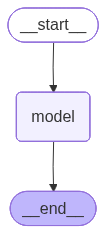

In [12]:
agent

In [13]:
agent.invoke({"messages":[("user","Hi there !")]})

{'messages': [HumanMessage(content='Hi there !', additional_kwargs={}, response_metadata={}, id='eb0af698-b98f-497d-8c75-0ecb2e65237c'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 38, 'total_tokens': 62, 'completion_time': 0.02666276, 'completion_tokens_details': None, 'prompt_time': 0.003642782, 'prompt_tokens_details': None, 'queue_time': 0.074843978, 'total_time': 0.030305542}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6c980774ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1ac9-3625-7fa3-89b7-e4aec45600a2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 38, 'output_tokens': 24, 'total_tokens': 62})]}

# Adding dummy tool

In [14]:
from langchain.tools import tool

In [15]:
@tool
def dummy_tool(inputText: str) -> str:
    """Convert input text to uppercase. This is just for testing.
    
    Args: 
        inputText {str} -- input text to be converted to uppercase
    """

    return f"Output : {inputText.upper()}"

In [16]:
tools = [dummy_tool]

agent_dummy_tool = create_agent(llm_groq, tools=tools)

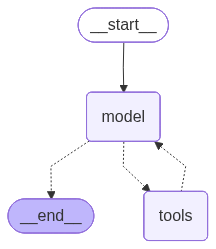

In [17]:
agent_dummy_tool

In [18]:
res = agent_dummy_tool.invoke({"messages":[("user","use the dummy tool on 'react agents' ")]})

In [19]:
res

{'messages': [HumanMessage(content="use the dummy tool on 'react agents' ", additional_kwargs={}, response_metadata={}, id='b4c6da72-858c-4ec6-88ea-49cea69711d5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'skv78pesc', 'function': {'arguments': '{"inputText":"react agents"}', 'name': 'dummy_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 275, 'total_tokens': 292, 'completion_time': 0.027490908, 'completion_tokens_details': None, 'prompt_time': 0.023880457, 'prompt_tokens_details': None, 'queue_time': 0.195095825, 'total_time': 0.051371365}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1ac9-3781-77d1-bb54-17e6962bc736-0', tool_calls=[{'name': 'dummy_tool', 'args': {'inputText': 'react agents'}, 'id': 'skv78pesc', 'type': 'tool_call'}], invalid_tool_calls=

# Adding weather tool

In [20]:
import requests

In [21]:
@tool
def get_weather(city:str)-> dict:
    """ Get the current weather for a given city"""
    try:
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1&language=en&format=json"
        geo_data = requests.get(geo_url).json()
        if not geo_data.get("results"):
            return {"error": f"City {city} not found"}
        location = geo_data["results"][0]
        lat, lon = location["latitude"], location["longitude"]
        print(lat,lon)
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code"
        data = requests.get(weather_url).json()
        temp = data["current"]["temperature_2m"]
        return {"city": city, "temp":temp,"unit":"C"}
    except Exception as e:
        return {"error":str(e)}

In [22]:
print(get_weather.invoke("Kolkata"))

22.56263 88.36304
{'city': 'Kolkata', 'temp': 15.6, 'unit': 'C'}


In [23]:
tools.append(get_weather)

agent_weather = create_agent(llm, tools = tools)

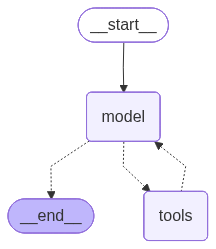

In [24]:
agent_weather

In [25]:
agent_weather.invoke({"messages":[("user","Can you give me the current temperature of Middletown")]})

40.39428 -74.11709


{'messages': [HumanMessage(content='Can you give me the current temperature of Middletown', additional_kwargs={}, response_metadata={}, id='36ecb397-71f6-4997-8ccd-3d23b49a1fd2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Middletown"}'}, '__gemini_function_call_thought_signatures__': {'7dea7a91-1612-4955-8fa2-3b9bd0c9df38': 'CswCAXLI2nxScGSukp/PPw2qaibhkXmmQnYIEhnZKK8FEuAAMft+PI5MZdUXp04OR1rUy/M/VUqKNdhAvj6yqlbI/E52/kGydKphn9PBw767Qzusjo1YAPYgSIGK5bwJqdkkyQfSqumf/IA99Yqxjv+eXTpOKZwiNWDo6nBHotK1MeBa8jixFy6+69/xgrzlL3Sm1h2/V3jmgOSllma1gD1wjK8GhZZU8dKwRP8K9kT6eGrBcnjzk9puHVZ7jGCYBfKswWRuNCff08MZDfJemnLpDC/zd31G/ACKYFzBIwi4dKwIvGtk8+8AHVYiBC4SwgFXNspYu3XRZIXBkQ2oX2epThn7Y3PkOV3sscc/VW7xkz1yiUV5TfiNEiIIkbEo78rJ80Q6D+smAon8ETxq3ROQnZ46iUsHNFeGch67Y98CbMPRrGC1Vk353oIDDoY='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1ac

In [26]:
agent_weather.invoke({"messages":[("user","Can you convert 'hello there' in uppercase and also give me the current temperature of Delhi and Kolkata.")]})

28.65195 77.23149
22.56263 88.36304


{'messages': [HumanMessage(content="Can you convert 'hello there' in uppercase and also give me the current temperature of Delhi and Kolkata.", additional_kwargs={}, response_metadata={}, id='6eb5965c-aa66-4729-b82a-01b1af6c0f73'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Kolkata"}'}, '__gemini_function_call_thought_signatures__': {'44d3a7b7-eedd-4b8b-9f24-1ab749ce97fe': 'CpIDAXLI2nyhGClTT89YEh15OIIGWxVU8TecZbuvLw5ZjxfM5ak6NeWKLTp0IgLUAgB8OBCWeJq0ixQiPnTd8bJM4tLFFPYDv+mclJGD2dNAGrE19mdSJfdkGc0B3S5T9D/1qJGOClrcVEwwFTR69cndQYv8xBqhT0W3fOhMHS6qbDqUCqoAs3HbFiO8JZR3zSQxVX2+2m4pfD2rtluq9AqqajIjMIcsL8EbLSp5oLNGqOQ1Y4lTuamnfvlx5p8ksXZqQn0EJOdxb3AzdGNilX6NfQ+fD10+v3brU2J6oUSpYX4aNxnupn9gp6z33piR+DnBFS6zaCArjtXC11PWE2udn/a+yYui0lPlBe6IxIbqaxzj8NEkUYNBpo42Sp/G7LHQ6hsER3BxgQIFVKvM/4ZgaGhY4AibeR/ElVn++KzeP9vwoGqjxalf2QFJoIMLbuEb4iSNKAEE+mPO1ZiKe0pcJrtqrgq1PyWX2yl5jk0RtxBNp581Eqww7Q3SUZra59Zn2EvpJJ0NnqlhNAdc7WT33fPY'}}, response_meta

## Notes Tool Implementation

In [27]:
@tool
def get_notes() -> list:
    """Get all pending notes from Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return ["Error: Notion API Key or DB id not set"]
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url = f"https://api.notion.com/v1/databases/{db_id}/query"

    payload = {
        "filter":{
            "property":"Status",
            "select":{
                "equals":"Pending"
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        data = res.json()

        notes = []
        for page in data.get("results",[]):
            props = page.get("properties", {})
            title_list = props.get("Note", {}).get("title", {})
            note_content = title_list[0].get("text",{}).get("content", "") if title_list else "Untitled Note"
            notes.append(note_content)

        return notes
    
    except Exception as e:
        return [f"Error Fetching Notes: {str(e)}"]

@tool
def add_notes(note:str)->str:
    """Add a new note to Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return "Error: Notion API Key or DB id not set"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url="https://api.notion.com/v1/pages"


    payload = {
        "parent" : {"database_id":db_id},
        "properties":{
            "Note":{
                "title" : [{"text":{"content":note}}]
            },
            "Status": {
                "select":{"name": "Pending"}
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        return f"Note added successfully: {note}"
    except Exception as e:
        return f"Error adding note: {str(e)}"

## Add Calendar tools

In [36]:
import requests
@tool
def get_calendar_events(date: str) -> dict:
    """
    This tool will get calendar events for a specific date (YYYY-MM-DD) from Notion.
    """
    api_key = os.getenv("NOTION_API_KEY")
    calendar_db_id = os.getenv("NOTION_CALENDAR_DB_ID")

    if not api_key or not calendar_db_id:
        return {"error":"Key is not set"}

    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url = f"https://api.notion.com/v1/databases/{calendar_db_id}/query"

    payload = {
        "filter":
            {
                "property": "Date",
                "date":{
                    "equals":date
                }
            }
    }

    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(data)
        events = []
        for page in data.get("results",[]):
            props = page.get("properties",[])
            #Extracting the event title
            event_title_list = props.get("Event",{}).get("title",[])
            event_name = event_title_list[0].get("text",{}).get("content","") if event_title_list else "Untitled event"
            #Extract the event time
            time_list = props.get("Time",{}).get("rich_text",[])
            event_time = time_list[0].get("text",{}).get("content","") if time_list else "All day"
            events.append({
                "event": event_name,
                "time": event_time
            }
                )
        return {"events":events, "date":date}
        

    except Exception as e:
        return {"error": str(e)}


    
    






In [41]:
get_calendar_events.invoke("2026-01-31")

{'object': 'list', 'results': [], 'next_cursor': None, 'has_more': False, 'type': 'page_or_database', 'page_or_database': {}, 'request_id': 'e9f0199d-26e5-4ee6-9602-384c1eaa3e86'}


{'events': [], 'date': '2026-01-31'}

In [45]:
@tool
def add_calendar_event(date:str, time:str, event:str)-> str:
    """
    this tool will be used to add calender events in notion.
    You have to provide date (YYY-MM-DD), time(HH:MM), event(description)
    """

    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_CALENDAR_DB_ID")

    if not api_key or not db_id:
        return {"error":"Keys not set"}
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url="https://api.notion.com/v1/pages"

    start_datetime = f"{date}T{time}:00" if time else date

    payload = {
        "parent" : {"database_id":db_id},
        "properties":{
            "Event":{
                "title":[{"text":{"content":event}}]
            },
            "Date":{
                "date":{"start":start_datetime}
            }
        }
    }

    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return f"Added Event:{event} at {time} on {date}"
    
    except Exception as e:
        return f"Error : {str(e)}"

In [46]:
add_calendar_event.invoke({
    "event": "Productivity Analysis",
    "date": "2026-02-01",
    "time": "21:00"
})

'Added Event:Productivity Analysis at 21:00 on 2026-02-01'

## Multi Tool ReAct Agent

### Setup

In [ ]:
from dotenv import load_dotenv
import os, requests
from langchain.agents import create_agent
load_dotenv()

True

### Weather tool

In [ ]:

from langchain.tools import tool
@tool
def get_weather(city:str)-> dict:
    """ Get the current weather for a given city"""
    try:
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1&language=en&format=json"
        geo_data = requests.get(geo_url).json()
        if not geo_data.get("results"):
            return {"error": f"City {city} not found"}
        location = geo_data["results"][0]
        lat, lon = location["latitude"], location["longitude"]
        print(lat,lon)
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code"
        data = requests.get(weather_url).json()
        temp = data["current"]["temperature_2m"]
        return {"city": city, "temp":temp,"unit":"C"}
    except Exception as e:
        return {"error":str(e)}

### Calendar Tool

In [48]:
@tool
def get_calendar_events(date: str) -> dict:
    """
    This tool will get calendar events for a specific date (YYYY-MM-DD) from Notion.
    """
    api_key = os.getenv("NOTION_API_KEY")
    calendar_db_id = os.getenv("NOTION_CALENDAR_DB_ID")

    if not api_key or not calendar_db_id:
        return {"error":"Key is not set"}

    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url = f"https://api.notion.com/v1/databases/{calendar_db_id}/query"

    payload = {
        "filter":
            {
                "property": "Date",
                "date":{
                    "equals":date
                }
            }
    }

    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(data)
        events = []
        for page in data.get("results",[]):
            props = page.get("properties",[])
            #Extracting the event title
            event_title_list = props.get("Event",{}).get("title",[])
            event_name = event_title_list[0].get("text",{}).get("content","") if event_title_list else "Untitled event"
            #Extract the event time
            time_list = props.get("Time",{}).get("rich_text",[])
            event_time = time_list[0].get("text",{}).get("content","") if time_list else "All day"
            events.append({
                "event": event_name,
                "time": event_time
            }
                )
        return {"events":events, "date":date}
        

    except Exception as e:
        return {"error": str(e)}


In [49]:
@tool
def add_calendar_event(date:str, time:str, event:str)-> str:
    """
    this tool will be used to add calender events in notion.
    You have to provide date (YYY-MM-DD), time(HH:MM), event(description)
    """

    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_CALENDAR_DB_ID")

    if not api_key or not db_id:
        return {"error":"Keys not set"}
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url="https://api.notion.com/v1/pages"

    start_datetime = f"{date}T{time}:00" if time else date

    payload = {
        "parent" : {"database_id":db_id},
        "properties":{
            "Event":{
                "title":[{"text":{"content":event}}]
            },
            "Date":{
                "date":{"start":start_datetime}
            }
        }
    }

    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return f"Added Event:{event} at {time} on {date}"
    
    except Exception as e:
        return f"Error : {str(e)}"

### Notes Tool

In [50]:
@tool
def get_notes() -> list:
    """Get all pending notes from Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return ["Error: Notion API Key or DB id not set"]
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url = f"https://api.notion.com/v1/databases/{db_id}/query"

    payload = {
        "filter":{
            "property":"Status",
            "select":{
                "equals":"Pending"
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        data = res.json()

        notes = []
        for page in data.get("results",[]):
            props = page.get("properties", {})
            title_list = props.get("Note", {}).get("title", {})
            note_content = title_list[0].get("text",{}).get("content", "") if title_list else "Untitled Note"
            notes.append(note_content)

        return notes
    
    except Exception as e:
        return [f"Error Fetching Notes: {str(e)}"]

In [51]:
@tool
def add_notes(note:str)->str:
    """Add a new note to Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return "Error: Notion API Key or DB id not set"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url="https://api.notion.com/v1/pages"


    payload = {
        "parent" : {"database_id":db_id},
        "properties":{
            "Note":{
                "title" : [{"text":{"content":note}}]
            },
            "Status": {
                "select":{"name": "Pending"}
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        return f"Note added successfully: {note}"
    except Exception as e:
        return f"Error adding note: {str(e)}"

In [103]:
all_tools = [
    get_weather, get_notes, get_calendar_events, add_calendar_event, add_notes]

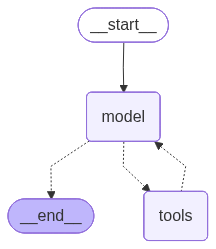

In [104]:
agent = create_agent(llm, tools=all_tools)
agent

In [85]:
query = "What are my upcoming events for 1st of February, 2026?"

In [86]:
response = agent.invoke({"messages":["user",query]})

{'object': 'list', 'results': [{'object': 'page', 'id': '2fa45c75-96fd-8138-95d9-fba51e391f8b', 'created_time': '2026-02-01T20:37:00.000Z', 'last_edited_time': '2026-02-01T21:33:00.000Z', 'created_by': {'object': 'user', 'id': 'd2006e8c-dd48-4c77-9431-68c75adbab90'}, 'last_edited_by': {'object': 'user', 'id': '6430b6b6-01ee-4c25-a8d1-ed4c79ab9926'}, 'cover': None, 'icon': None, 'parent': {'type': 'database_id', 'database_id': '2f645c75-96fd-8179-b318-ea8cd0bf1de8'}, 'archived': False, 'in_trash': False, 'is_locked': False, 'properties': {'Date': {'id': '%5DxB%5B', 'type': 'date', 'date': {'start': '2026-02-01T21:00:00.000+00:00', 'end': None, 'time_zone': None}}, 'Time': {'id': '%5EnR%5C', 'type': 'rich_text', 'rich_text': []}, 'Status': {'id': '%7DSfd', 'type': 'select', 'select': {'id': 'c2fba431-c2bc-4878-81f8-05e2de69c494', 'name': 'Upcoming', 'color': 'blue'}}, 'Event': {'id': 'title', 'type': 'title', 'title': [{'type': 'text', 'text': {'content': 'Productivity Analysis', 'link':

In [87]:
response

{'messages': [HumanMessage(content='user', additional_kwargs={}, response_metadata={}, id='4d76e54e-ec1d-4f46-a66e-8e1489126531'),
  HumanMessage(content='What are my upcoming events for 1st of February, 2026?', additional_kwargs={}, response_metadata={}, id='1499eb6f-49a2-4202-81a6-bcdbb5af398f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_calendar_events', 'arguments': '{"date": "2026-02-01"}'}, '__gemini_function_call_thought_signatures__': {'03271dc0-6965-451a-ac92-646405a96d1c': 'CvcCAXLI2nwHMkMwVHEzOGN1N3wWteS84pyDdyXJ/NW1JQZJbrblCPOW7cFUafafH8YE9Gd+yOmze5UR5bIP7A7hg91A+uzAuARQ4ZNicnwfFB17thillO6sLSmCsgve+mqY2PKZEFWjb7fiPd6qtYbIqD8eNLhWNvY17Dg86aPLfsle2IW1QouauG4dbiA7hU+rUoukctjG0SlZKaVMBlu3n5YidMvV32fyI/8U8xCpuzPZXrUTLOPRBpZyWELp6wIvJhbWGcHXt1ehOKEoQLtg0lCtMrIVxZYaVUileVVBDIYpU5TtqqUrXlpuR5EU18bjhRZ4OplFTCA7QsvNM2EsNEuilwjkmN2jkV1zjrZRA2pfygvbyQmpiEzVjoK4i4VPZsVRErZeXi4cfOI8jtIU2X/dnKNsT7tZJqC1CRJPMQKwG+TANpkIFhdhpTJER3PiHNZ1Pi+rrNg6F5ViAJc4L1YvNrx

## ReAct Agent with System Prompt

In [109]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",      # Changed from 2.5 (which likely doesn't exist) to 1.5
    google_api_key=os.getenv("GEMINI_API_KEY"), temperature=0.7 # Changed parameter name
)

print(llm.invoke("Hello, how are you?"))

content=[{'type': 'text', 'text': "I'm doing well, thank you for asking! How can I help you today?", 'extras': {'signature': 'EqYMCqMMAXLI2nz6MiD0gi446y/JLcYiXA55w0VzIVzh78/TY8NE5SpsoDZHws80xKcmYnWPNKMmmkXJhPN1kU3m5fnEwAIU7Lx0waLJ3ax0pAOqi+eqjSpZK4fxkWMB5H9yAeRh/N2HR/1EzO8E3z6JshAkoB1+0SRjCKsevCwwlwo621z/bQ8Bm4KNnO16kpKAcjZ5iECn5DwyvdG2/5XmMcLLBTu7mMaOBdu7UgMgE5vM68EcjjZVOx6/Fn1LQQSeVKsqWXzNXVO4GYGdcNE/94bPQQjqgKjbo+cUbyJvYko7l9+aV6escIQ/+8wCXAeAJ49oqyVEhBV5JMecGeLIV2OjivMF+7f7hHZgBsSrJ4xaRmUxzIx0ywmpKk8wYaoeL1E+c5ndgHZrOpF342sMBggGB19lkPcuIP5iAsYCJF1ZR3AQCrFog1ST3i+vyH3eZKMNUNyI7nxey3MkyugPdRkInFbl5GfSge54wi3r8kXoGDfVca8Iyzna4ny0wxVYpcMPVztxc8bapdm3lE0hjIiQY20ZYcs6qqoB5pmqSJ60APmFVonZc3hFm6XDVb7OfSnTB1+z8V+grgLGGZb8hILbRAni3Py4MMbaxcUkZuiHDV94pLd8n5BUaUY/lYi3kr2/wzZZnjEN15vKVUpJpxJrAK8pZMRkg9DxTzEYsrtqQsm0OzTGnI9n9Fr/MYluvSCG+OWSpN8Z6J+tKY41LtvN1tNYjh6sytD+k7geGqXlHAvkUD8gHQGhCZh77A9/r8eV/nMlUByxPx4P+1L3CXn/AyvQ0IvDo1rxdZLa5GyFjPomQP7laLPouGqZTN5xUGuiIAKh8EcZ7FVIH7qbrTp+kTcKbWF7p0Qzt2

In [110]:
import datetime

# Dynamic Context Variables
now = datetime.datetime.now()

system_prompt = f"""# Role & Goal
You are a **Smart Day Planner ReAct Agent** that helps users plan, prioritize, and optimize their day. 
Your goal is to act as a personal productivity assistant—not just executing commands, but reasoning about the user's schedule to create a realistic and actionable plan.

# Capabilities
- **Notion Integration**: You can fetch pending notes (`get_notes`) and add new ones (`add_notes`).
- **Calendar Management**: You can query and add events to the calendar (`get_calendar_events`, [add_calendar_event].
- **Context Awareness**: You can check the weather (`get_weather`) to inform planning (e.g., suggesting indoor tasks if it rains).

# Dynamic Context
- **Current Date**: {now.strftime('%Y-%m-%d')}
- **Current Time**: {now.strftime('%H:%M')}
*Use this context to resolve relative terms like "tomorrow," "this afternoon," or "next week."*

# Task Instructions
1. **Reason before Acting**: 
   - Analyze the user's request.
   - Check existing commitments first (use `get_calendar_events`).
   - Considerations priorities, trade-offs, and logical flow.
2. **Execute Choices**:
   - If adding a calendar event ([add_calendar_event], default the status to "Upcoming" unless specified otherwise.
   - If a tool fails (e.g., "Not Found"), handle it gracefully and inform the user.
3. **Optimized Planning**:
   - Break work into focused blocks.
   - Avoid overload; ensure the plan is physically possible given the current time.

# Critical Constraints
- **Do not invent events**: Only reference events that actually exist in the DB or were explicitly requested.
- **Clarify Ambiguity**: If the user says "Add a meeting" without a time/date, ask for details instead of guessing.
- **Be Concise**: Return output in a clear, structured format (e.g., bulleted time blocks).

Example Output Format:
- [09:00 - 10:00] Deep Work: Project X
- [10:00 - 10:30] Catch up on emails (3 pending notes found)
"""

In [111]:
agent_with_sys_prompt = create_agent(llm, tools= all_tools, system_prompt= system_prompt)

In [113]:
response = agent_with_sys_prompt.invoke({"messages":["user","I want ou to help me plan my day tomorrow. I want to wake up at 6:30 am and then get ready for 30 mins. Then I want to read a book for 30 mins and then in any order you think is appropriate I want to get some deep work done for arounf 3 hours where I wil do my leetcode, also I need to talk to my famly for 2 hours, I will also have my lunch while talking to them. I would also like to do some cold applications for jobs and build the rest of this project before going to bed. Please plan my day and add it to my notion calendar. Please keep in mind my day starts at 6:30 am."]})

{'object': 'list', 'results': [], 'next_cursor': None, 'has_more': False, 'type': 'page_or_database', 'page_or_database': {}, 'request_id': '46ea8f73-85e0-4663-b51e-c728f5dc1469'}


In [114]:
response

{'messages': [HumanMessage(content='user', additional_kwargs={}, response_metadata={}, id='c8334822-bfb1-4bdb-805f-0d1500ee9e35'),
  HumanMessage(content='I want ou to help me plan my day tomorrow. I want to wake up at 6:30 am and then get ready for 30 mins. Then I want to read a book for 30 mins and then in any order you think is appropriate I want to get some deep work done for arounf 3 hours where I wil do my leetcode, also I need to talk to my famly for 2 hours, I will also have my lunch while talking to them. I would also like to do some cold applications for jobs and build the rest of this project before going to bed. Please plan my day and add it to my notion calendar. Please keep in mind my day starts at 6:30 am.', additional_kwargs={}, response_metadata={}, id='691276a1-4b3b-45aa-8532-235010e4213d'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'get_calendar_events', 'arguments': '{"date": "2026-02-02"}'}, '__gemini_function_call_thought_signatures__': 

In [ ]:
{'messages': [HumanMessage(content='user', additional_kwargs={}, response_metadata={}, id='c8334822-bfb1-4bdb-805f-0d1500ee9e35'),
  HumanMessage(content='I want ou to help me plan my day tomorrow. I want to wake up at 6:30 am and then get ready for 30 mins. Then I want to read a book for 30 mins and then in any order you think is appropriate I want to get some deep work done for arounf 3 hours where I wil do my leetcode, also I need to talk to my famly for 2 hours, I will also have my lunch while talking to them. I would also like to do some cold applications for jobs and build the rest of this project before going to bed. Please plan my day and add it to my notion calendar. Please keep in mind my day starts at 6:30 am.', additional_kwargs={}, response_metadata={}, id='691276a1-4b3b-45aa-8532-235010e4213d'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'get_calendar_events', 'arguments': '{"date": "2026-02-02"}'}, '__gemini_function_call_thought_signatures__': {'78bbd8cc-9c2e-4b02-9b87-c06c9ff04066': 'Eq0NCqoNAXLI2nwGOpNoHmFqHxuJb/uyuWl/OyRt08LoKf/Tjszuf28rWa52qs1S2DoBSCJ50koYC7fhT6DHt1LGaU20eMJNftSpOrXK7iLGCZgvhyOpqa45VpuCE6NjGlLvMWHfzRbfSeQpH0hn1Q12atUk6C544GgU1kmtbT01O0vjIp1rFlz6BdieGQscJJfPv1yg/0dGlhXvObOkhs+nz1+4mcwkZoNqWapneYwSOh2vIfKX3RQZaGbc6IfAJMCcK7AIijXKBe3TIcwmpz9NrmRqx54Y/W8ei+ozwrN6wZYqxo7K8EielhWbpJFog3Ty84P18QFwvU2ooKSQddk1BFfYvIRzu0EI5D0XrlSRl1SpJ8Uh6VZ+YlraI/2Jqgo/Hd3N4tLXA4fLLZ7LuX68tCSb2Z1rqsXCVslHG5UYFPUtax/jY1ehIlJaAM0I5jTiAD0RtNvDCSXjmmzBxn7wXG6ILOXV/ElYPty7GtViFH5a4d2o/vikdWDk8gU76U3hk4qPM+M+UHOQR2n546sCV6DOUtqeDgNS6tborPM4fXd9HKW+DzrLOVLdVp0gdxAt7VAC5PYB2fOtMt9LIPmaqs+L6gfo/wxPbL6RRzFysGpuHY2asCBgiI1gDg/gqurG4YHyZ0l8ltFaLLYv31ixC1ii87D/rrGOgUvwZpZcyzPB9LGCkJTN/inio+EpXf6bx0eDhPUWy+n8H9GPx30KnrXx7a6Yk7EmL2oydtvUpC9M5E9oAYuumdMzDrj5HHGkFAK73hHF4ArjsNjN2+XdWvbFGU7oms6sEdJrhaVfjh3Ex1p6YV0yAjBmefI7QRkexjO37c8/FWCsA/u8KT7mp2zP4KOod40Sg8zj9ThogB+ujtJzlrBr+oEhxX0nFSDKJ27jewcSt11V2DT67ZWpswvG514664T8AmH9tvCLSHDgxqykIHkj2VQANLhlFo1MJ90dXx0cvmN17XqIgMhB3axsf6UT/zUyp7xF2iCpBsCPbNUFqedDbuJh09+SSEI8exJ5+P8X6olV16+zrAPwssTCg+j9Abh98rKn6Ll4f8rPL+jxzA8j0gsyqssCp4aYudo6X1QaBB4/4WEniCqMNf6EX+G6+vA2Rvgs9KBkqam23qANetWPpRxVu0Oyqjkn/QThzEgQBq/iTVih8hbVmgnWHFBJBpeeS/QV7eqkYCtJOIgFf1YD/OE2CwdgNKQI9+6GkrZ86sj2xaF3BAS+vkAdyOfZPFBD1CytacJgPqOb8EymeDQbYpf1NR+lELl5dL+EhkgFN1aVqjKs11L81lCpRQSbsajIntU8a11rJRjWmnH02zYsUklHe8OVUKgmm555DcvgN94slhxJ0RE19XLFlfyAtfeh2u6J3oxJFMooTzZR2o51TwxVk0y4xVw32fVdAnAt61EQje2ISuofoLMFUCJoIgjxVqBG6z0Y9ObECTQl8zwCRU5HyNl8Pgc9b3eH50rRIr36l7hN1TfE5EYw4R1nlJ8wzBvOOMzOM2+FUiWmL/Flwgt2uYkD8h8sqPS4+8jQxoQSf/0xz2z1MLfbBxHv3jlk/YiyZ3i8yfY5kcS1U3dAQ5t9vE5tX3z2pFyjuCWM+lKOCnIfeFr0ETKQ12dL+Du5LnulIUndA/5p1mfz9Fd8Jn2uyM1i9AKBmjVdW3ViEAEcAeHX7V3dDLyQ4w9WCIVareTHUGmB5VeYcY2w6ufDICwDHeNSpHcfFfedGkod8klB2PlRuTAaVizPpe/unfZltLvhrF+9vi/jsoFiqw66eB1OmY0kZTSaClQoDBdYsUliweqE+RGE9IjMzHeuAF45BnODt8JjDCgcUoaCnYIoeFwkr/iHRSz9MKYwrOlSzklWlrQ1He2EVAlVHq4EmcWWbUaRBs2Dv8jpUKduQTpEy8Ngw+8Yf0embp5eMrA3rcTrR5ksmkhE50YML/Isn5yOqmjEb7YxB2K6n/7yM0/q5N/JBkrahQbRfBpwZJnSF80SNxqtOvvjZhnGL7eO+4LMPHgL4b8Lr0nrol7Ibo/afuoJo4xWzlL1J7NIbAwVeW0i5E/T1SMdgG/6FahAAODMeeOjBWjAjwzjEckP0XE1Ey5TFU7a+d6Ye7SxVJVJjtI8eifa7r59+qqWiCbFqgRRJQjlQ/tlpDj9j29J7HjmnBh+XAPf1X4Oc/ZodgNcVfGwo/5gGYk9fSBN4+ag9ORgZbqET8MULjSDqldaqcbhSDzhrqebdfwKmHs8byI16AnS7WVecwaF7fvYpq0R8DE8Ec6BsQM='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-pro-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1b54-b727-7551-8881-a98e1ed6bc80-0', tool_calls=[{'name': 'get_calendar_events', 'args': {'date': '2026-02-02'}, 'id': '78bbd8cc-9c2e-4b02-9b87-c06c9ff04066', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 905, 'output_tokens': 517, 'total_tokens': 1422, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 490}}),
  ToolMessage(content='{"events": [], "date": "2026-02-02"}', name='get_calendar_events', id='a7b87374-838e-40bc-9386-75c5c31ffd6a', tool_call_id='78bbd8cc-9c2e-4b02-9b87-c06c9ff04066'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'add_calendar_event', 'arguments': '{"date": "2026-02-02", "time": "14:00", "event": "Build Project"}'}, '__gemini_function_call_thought_signatures__': {'4d87257d-e29e-4428-a6ba-be6e22d84ed3': 'EqgICqUIAXLI2nzm4qRkaTvOxAemxcZ/CLCR0ZrOu3VpOt22t8hKZ69A39w7qM0EOjKe8X4CHIoaNrFWafWxyLz9u54DW9b6rVJUjNIS0RU+/T1LkFpYQxR64CnBLPDDAoxWD5jJ0ELF5BAFJMiMtSjPPPXEnniqkzEpxn/92Av7QatsPCyDngFc9jpzNTwxlKukvGiK/u+qmVIyzr7OPOJ08LL0r+71rWx5mqwt8lbUF4HfesdKwbm0EVo/iKiVlM+FJSdD/bGdVFdeR/bUrvU69QBKDKDbODs7qMJTN999+2tsupirW3cVQiISh4EWFXvhcgqRIBSEUDxZ6usg0ghQziq7Q3IGoyCvTDJfAnn5jKQk4DfwZs93nk1yjKRwBvGgsAbzf0BGV18Q9euRfGtnPGnwCYv8QMhXfsQa41g/TewYUjZzHrZqk+xglGRd43Apc6doWGEElKgHsINvzFSxU/NDjoLNAQxeDVaQPqwAP5Nr265v8vgAuQEzyuvXKPxq5L00N+Yr/wuxm7HxJvaAG60RzNJ/PCdE/sYubMbla4TvSjq9BUMbpolrqOLdxgqQa2oM46IzOwSo05cbisTy67xFWsXWKUWNSmmDHXKZkW+XJrlOrIAixcaizd2fwt7HfkIo9RYnXiew636E4/D+tsT5jX6z3yqk+PUu2FHfsI3nYoIMNYDfP9T9X/kCc2MI4fVTkn2dBn+C+jEnQvQGSKIVQHg+eYz/FimDhlunLML3PEoYo+p0csgFEWpbpX3Jlj/fJnmnEpsGIU8nDN4saspc5d90ZT2y1RQ6xyzvHqnIlolNsxNunBvIPhwk9/J22eSXsFCQv4tLRGDCysWSlNdrsuXhu7Qf2fYCPw2/WbLDRAye0B/R/ZvRJuQABeBKnaSYOaCrJFwJeeV3SgGqSmQR8sftuMq0ZcvXxTa2cBB7HcKA4cRZRQmjv5155bKyoIGIftz7UFBXJmq5Juwv4HFg2qlYPd1/V8FrGS7Al2qAod3Szqiig2Ac3fIQp2E1+HQ2KkrTIKb24XFwID5kHeW9vkhpUHMgqrpi3k9GG2de3MEpyhWb9bPxNFcmJT5iWInjTyUyj7lTqGQnhvk1konPJ+iM+MTP+IiRDKBTICUqRj6y4ECoilYrB75GH/ADAv1XZ56QRiquLtc+7juy+5h0mgtCt+C9uFL+toYeU/1LucnA7HMGzc5olB5UEkHXQYDVJ+5rlm5Y71QzeVfUG0LDcj9BLhSxLGF+euQXGxITt+Diijse/4v02TD1b+7S0318OlB8aSpUZ4Hsxw8+jFYIv/ULbHDyyk3GWinBg4gjm62BUoDfe1NgkowAyXunKuAKlDQX0AVhoQYjJTNzlBJMV0X/SOqJzuNgkJ8qxs57Uon5TfDRS6Yr/suE64TPVHmGHa7Pr1c='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-pro-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1b54-d15f-7833-97b7-bb468ab3628b-0', tool_calls=[{'name': 'add_calendar_event', 'args': {'event': 'Get Ready', 'date': '2026-02-02', 'time': '06:30'}, 'id': '4d87257d-e29e-4428-a6ba-be6e22d84ed3', 'type': 'tool_call'}, {'name': 'add_calendar_event', 'args': {'time': '07:00', 'date': '2026-02-02', 'event': 'Read a Book'}, 'id': '7201a93d-1838-4037-b9a1-a6451c9131d8', 'type': 'tool_call'}, {'name': 'add_calendar_event', 'args': {'time': '07:30', 'date': '2026-02-02', 'event': 'Deep Work: Leetcode'}, 'id': 'ec0b3499-3d8e-4b6d-9902-21f654a0184a', 'type': 'tool_call'}, {'name': 'add_calendar_event', 'args': {'event': 'Cold Job Applications', 'time': '10:30', 'date': '2026-02-02'}, 'id': 'e5b8443a-97d1-4517-82d5-80f2e521b833', 'type': 'tool_call'}, {'name': 'add_calendar_event', 'args': {'time': '12:00', 'date': '2026-02-02', 'event': 'Family Time & Lunch'}, 'id': '8215feb8-ee9b-4c0f-a5f5-11452e205a54', 'type': 'tool_call'}, {'name': 'add_calendar_event', 'args': {'date': '2026-02-02', 'time': '14:00', 'event': 'Build Project'}, 'id': '7a6d9082-8697-4802-87b7-fc321cc16273', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 1450, 'output_tokens': 647, 'total_tokens': 2097, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 375}}),
  ToolMessage(content='Added Event:Get Ready at 06:30 on 2026-02-02', name='add_calendar_event', id='7f4a7c14-fab9-43e9-bc85-d6574697ffd5', tool_call_id='4d87257d-e29e-4428-a6ba-be6e22d84ed3'),
  ToolMessage(content='Added Event:Read a Book at 07:00 on 2026-02-02', name='add_calendar_event', id='b06efe6e-f73d-4ff0-b228-9b3827268b15', tool_call_id='7201a93d-1838-4037-b9a1-a6451c9131d8'),
  ToolMessage(content='Added Event:Deep Work: Leetcode at 07:30 on 2026-02-02', name='add_calendar_event', id='9210d9a0-d203-4bd4-b471-f887fb1039f6', tool_call_id='ec0b3499-3d8e-4b6d-9902-21f654a0184a'),
  ToolMessage(content='Added Event:Cold Job Applications at 10:30 on 2026-02-02', name='add_calendar_event', id='382702de-c6c8-47fd-816b-1c685dacc8f7', tool_call_id='e5b8443a-97d1-4517-82d5-80f2e521b833'),
  ToolMessage(content='Added Event:Family Time & Lunch at 12:00 on 2026-02-02', name='add_calendar_event', id='a6493218-9bd4-4c87-9ce4-2676d07aa913', tool_call_id='8215feb8-ee9b-4c0f-a5f5-11452e205a54'),
  ToolMessage(content='Added Event:Build Project at 14:00 on 2026-02-02', name='add_calendar_event', id='5985493f-d4ad-41bd-b89f-a4fe7f7303bf', tool_call_id='7a6d9082-8697-4802-87b7-fc321cc16273'),
  AIMessage(content=[{'type': 'text', 'text': "I've planned your day for **tomorrow, Monday, February 2nd**, prioritizing your deep work in the morning when focus is usually highest. I checked your calendar and found no conflicting events, so I've added this schedule to your Notion calendar.\n\n**Your Schedule for Tomorrow:**\n\n*   **[06:30 - 07:00]** **Get Ready**: Wake up and start the day.\n*   **[07:00 - 07:30]** **Read a Book**: A gentle start to stimulate your mind.\n*   **[07:30 - 10:30]** **Deep Work: Leetcode**: 3 hours of focused problem solving while your mind is fresh.\n*   **[10:30 - 12:00]** **Cold Job Applications**: Switching context to administrative tasks before lunch.\n*   **[12:00 - 14:00]** **Family Time & Lunch**: A 2-hour break to eat and connect with family.\n*   **[14:00 - Onward]** **Build Project**: Dedicated time to work on your project for the rest of the afternoon/evening until bed.\n\nAll events have been successfully added to your calendar. Have a productive day!", 'extras': {'signature': 'EoQCCoECAXLI2nwIzQuTSTCgtkVs+YnCzdNqZ9xKNCAua+4Y8J/ieA1WIY4iUnGM+9rEba9bVK/Z2nrpylYk1vGL6Xi/Z9Mhc2V/uUv6jCedG2dJvnhP/MC1GD7w+DIZqGoVFok/Vaug7xwu1aWqVlPLemjHyHI8lx3E5msSBYCwo7ItI73A6kbln05yxGehCnVEPtXIwMY+fAL7qc4PU46dSsFkwthl4HCE6OYaMFKjOBRJT2cW1cUjne8Q+C/7jxkWM3Jlhb50NsL3y3/SQqBzhvua71s4q5gg1S3FATQus3gczlClsEFaP9KpVjKIZS8FODGVZYhkI/gJ1rs6/FvCU41/jSg='}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-pro-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1b54-f6be-7b42-b373-031e2cb48ca3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2329, 'output_tokens': 326, 'total_tokens': 2655, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 42}})]}